## Setup

In [1]:
import json
import re
from copy import deepcopy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from datetime import datetime
import os.path
import copy
import seaborn as sns
import lovely_tensors as lt # can be removed

from l2o.others import w, detach_var, rsetattr, rgetattr, count_parameters, print_grads, \
    load_l2o_opter_ckpt, load_baseline_opter_ckpt, load_ckpt, get_baseline_ckpt_dir, dict_to_str
from l2o.visualization import get_model_dot
from l2o.training import do_fit, fit_normal, fit_optimizer, find_best_lr_normal
from l2o.regularization import (
    regularize_updates_translation_constraints,
    regularize_updates_scale_constraints,
    regularize_updates_rescale_constraints,
    regularize_updates_constraints,
    regularize_translation_conservation_law_breaking,
    regularize_rescale_conservation_law_breaking,
)
from l2o.analysis import (
    get_rescale_sym_constraint_deviation,
    get_translation_sym_constraint_deviations,
    get_scale_sym_constraint_deviation,
    get_baseline_opter_param_updates,
    collect_rescale_sym_deviations,
    collect_translation_sym_deviations,
    collect_scale_sym_deviations,
    collect_conservation_law_deviations,
)
from l2o.tail_index_utils import (
    alpha_estimator,
)
from l2o.data import MNIST, CIFAR10
from l2o.optimizer import Optimizer
from l2o.optimizee import (
    MNISTSigmoid,
    MNISTReLU,
    MNISTNet,
    MNISTNet2Layer,
    MNISTNetBig,
    MNISTRelu,
    MNISTLeakyRelu,
    MNISTSimoidBatchNorm,
    MNISTReluBatchNorm,
    MNISTConv,
    MNISTReluBig,
    MNISTReluBig2Layer,
    MNISTMixtureOfActivations,
    MNISTNetBig2Layer,
)
from l2o.meta_module import *
from meta_test import meta_test, meta_test_baselines

lt.monkey_patch() # can be removed
sns.set(color_codes=True)
sns.set_style("white")

In [2]:
### publication figure settings:
plt.rc("font", family="serif")

plt.rc("legend", fontsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("axes", labelsize=13)
plt.rc("axes", titlesize=13)
plt.rc("axes", linewidth=0.5)
plt.rc("axes", labelpad=10)

plt.rc("lines", linewidth=1.)

plt.rc("figure", dpi=300)
plt.rc("figure", figsize=(6, 4))

plt.rc("savefig", dpi=300)
plt.rc("savefig", format="pdf")
plt.rc("savefig", bbox="tight")
plt.rc("savefig", pad_inches=0.1)

In [41]:
### config
l2os = {
    ### MNISTReluBatchNorm
    "L2O - relu batchnorm": "26-04-2023_01-22-31_MNISTReluBatchNorm_Optimizer",
    # "reg_1e-2_scale": "03-05-2023_22-42-56_MNISTReluBatchNorm_Optimizer",
    # "reg_1e-1_scale": "02-05-2023_16-51-19_MNISTReluBatchNorm_Optimizer",
    # "reg_1e0_scale": "03-05-2023_22-42-36_MNISTReluBatchNorm_Optimizer",
    
    # "L2O - unroll 10": "10-05-2023_13-26-17_MNISTReluBatchNorm_Optimizer", # already collected
    # "L2O - unroll 20": "12-05-2023_00-38-54_MNISTReluBatchNorm_Optimizer", # lr: 1e-3, already collected
    # "L2O - unroll 30": "11-05-2023_01-27-43_MNISTReluBatchNorm_Optimizer", # already collected
    
    ### MNISTLeakyRelu
    "L2O - leakyrelu": "19-02-2023_18-20-21_MNISTLeakyRelu_Optimizer",
    # "reg_1e-2_rescale": "30-04-2023_13-08-09_MNISTLeakyRelu_Optimizer",
    # "reg_1e-1_rescale": "06-05-2023_01-54-04_MNISTLeakyRelu_Optimizer",
    # "reg_5e-1_rescale": "05-05-2023_01-42-29_MNISTLeakyRelu_Optimizer",
    
    # "L2O - unroll 10": "09-05-2023_20-50-27_MNISTLeakyRelu_Optimizer", # already collected
    # "L2O - unroll 20": "12-05-2023_00-35-50_MNISTLeakyRelu_Optimizer", # lr: 1e-3, already collected
    # "L2O - unroll 30": "10-05-2023_11-11-39_MNISTLeakyRelu_Optimizer", # already collected
    
    ### MNISTNet
    "L2O - sigmoid": "05-03-2023_01-33-57_MNISTNet_Optimizer",
    # "reg_1e-2_translation": "29-04-2023_01-35-00_MNISTNet_Optimizer",
    # "reg_1e-1_translation": "28-04-2023_13-45-29_MNISTNet_Optimizer",
    # "reg_5e-1_translation": "30-04-2023_12-41-11_MNISTNet_Optimizer",
    
    # "L2O - unroll 10": "09-05-2023_20-41-10_MNISTNet_Optimizer", # already collected
    # "L2O - unroll 20": "07-05-2023_20-52-18_MNISTNet_Optimizer", # lr: 1e-3, already collected
    # "L2O - unroll 30": "09-05-2023_20-42-08_MNISTNet_Optimizer", # already collected
}

baselines = {
    ### MNISTReluBatchNorm
    "Adam": "Adam_{lr=find_best_lr_normal}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=128}",
    "SGD": "SGD_{lr=find_best_lr_normal_momentum=0.9}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=128}",

    ### MNISTLeakyRelu
    # "Adam": "Adam_{lr=find_best_lr_normal}_MNISTLeakyRelu_{}_MNIST_{batch_size=128}",
    # "SGD": "SGD_{lr=find_best_lr_normal_momentum=0.9}_MNISTLeakyRelu_{}_MNIST_{batch_size=128}",

    ### MNISTNet
    # "Adam": "Adam_{lr=find_best_lr_normal}_MNISTNet_{}_MNIST_{batch_size=128}",
    # "SGD": "SGD_{lr=find_best_lr_normal_momentum=0.9}_MNISTNet_{}_MNIST_{batch_size=128}",
}

_baselines = {
    ### MNISTNet
    # "SGD_{lr=0.001}_{batch_size=8}": "SGD_{lr=0.001}_MNISTNet_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.01}_{batch_size=8}": "SGD_{lr=0.01}_MNISTNet_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.1}_{batch_size=8}": "SGD_{lr=0.1}_MNISTNet_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=1.0}_{batch_size=8}": "SGD_{lr=1.0}_MNISTNet_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=3.0}_{batch_size=8}": "SGD_{lr=3.0}_MNISTNet_{}_MNIST_{batch_size=8}",

    # "SGD_{lr=0.001}_{batch_size=16}": "SGD_{lr=0.001}_MNISTNet_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.01}_{batch_size=16}": "SGD_{lr=0.01}_MNISTNet_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.1}_{batch_size=16}": "SGD_{lr=0.1}_MNISTNet_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=1.0}_{batch_size=16}": "SGD_{lr=1.0}_MNISTNet_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=3.0}_{batch_size=16}": "SGD_{lr=3.0}_MNISTNet_{}_MNIST_{batch_size=16}",

    # "SGD_{lr=0.001}_{batch_size=32}": "SGD_{lr=0.001}_MNISTNet_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.01}_{batch_size=32}": "SGD_{lr=0.01}_MNISTNet_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.1}_{batch_size=32}": "SGD_{lr=0.1}_MNISTNet_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=1.0}_{batch_size=32}": "SGD_{lr=1.0}_MNISTNet_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=3.0}_{batch_size=32}": "SGD_{lr=3.0}_MNISTNet_{}_MNIST_{batch_size=32}",

    ### MNISTLeakyRelu
    # "SGD_{lr=0.001}_{batch_size=8}": "SGD_{lr=0.001}_MNISTLeakyRelu_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.01}_{batch_size=8}": "SGD_{lr=0.01}_MNISTLeakyRelu_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.1}_{batch_size=8}": "SGD_{lr=0.1}_MNISTLeakyRelu_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=1.0}_{batch_size=8}": "SGD_{lr=1.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=8}",
    # "SGD_{lr=3.0}_{batch_size=8}": "SGD_{lr=3.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=8}",

    # "SGD_{lr=0.001}_{batch_size=16}": "SGD_{lr=0.001}_MNISTLeakyRelu_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.01}_{batch_size=16}": "SGD_{lr=0.01}_MNISTLeakyRelu_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.1}_{batch_size=16}": "SGD_{lr=0.1}_MNISTLeakyRelu_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=1.0}_{batch_size=16}": "SGD_{lr=1.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=16}",
    # "SGD_{lr=3.0}_{batch_size=16}": "SGD_{lr=3.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=16}",

    # "SGD_{lr=0.001}_{batch_size=32}": "SGD_{lr=0.001}_MNISTLeakyRelu_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.01}_{batch_size=32}": "SGD_{lr=0.01}_MNISTLeakyRelu_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.1}_{batch_size=32}": "SGD_{lr=0.1}_MNISTLeakyRelu_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=1.0}_{batch_size=32}": "SGD_{lr=1.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=32}",
    # "SGD_{lr=3.0}_{batch_size=32}": "SGD_{lr=3.0}_MNISTLeakyRelu_{}_MNIST_{batch_size=32}",

    ### MNISTReluBatchNorm
    # "SGD_{lr=0.001}_{batch_size=8}": "SGD_{lr=0.001}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.01}_{batch_size=8}": "SGD_{lr=0.01}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=8}",
    # "SGD_{lr=0.1}_{batch_size=8}": "SGD_{lr=0.1}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=8}",
    # "SGD_{lr=1.0}_{batch_size=8}": "SGD_{lr=1.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=8}",
    # "SGD_{lr=3.0}_{batch_size=8}": "SGD_{lr=3.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=8}",

    # "SGD_{lr=0.001}_{batch_size=16}": "SGD_{lr=0.001}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.01}_{batch_size=16}": "SGD_{lr=0.01}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=16}",
    # "SGD_{lr=0.1}_{batch_size=16}": "SGD_{lr=0.1}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=16}",
    # "SGD_{lr=1.0}_{batch_size=16}": "SGD_{lr=1.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=16}",
    # "SGD_{lr=3.0}_{batch_size=16}": "SGD_{lr=3.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=16}",

    # "SGD_{lr=0.001}_{batch_size=32}": "SGD_{lr=0.001}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.01}_{batch_size=32}": "SGD_{lr=0.01}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=32}",
    # "SGD_{lr=0.1}_{batch_size=32}": "SGD_{lr=0.1}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=32}",
    # "SGD_{lr=1.0}_{batch_size=32}": "SGD_{lr=1.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=32}",
    # "SGD_{lr=3.0}_{batch_size=32}": "SGD_{lr=3.0}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=32}",
}

In [42]:
### load l2os from disk
for l2o_name, l2o_dir in l2os.items():
    ### load final l2o checkpoint
    ckpt = torch.load(os.path.join(os.environ["CKPT_PATH"], l2o_dir, "l2o_optimizer.pt"), map_location="cpu")

    ### load all metrics
    l2o_metrics = {}
    for metrics_file in [f_name for f_name in os.listdir(os.path.join(os.environ["CKPT_PATH"], ckpt["config"]["ckpt_base_dir"])) if f_name.startswith("metrics_")]:
        metrics_name = metrics_file[8:-4] # remove the "metrics_" prefix and ".npy" suffix
        l2o_metrics[metrics_name] = np.load(os.path.join(os.environ["CKPT_PATH"], ckpt["config"]["ckpt_base_dir"], metrics_file), allow_pickle=True).item()
    l2os[l2o_name] = {
        "ckpt": ckpt,
        "config": ckpt["config"],
        "metrics": l2o_metrics,
    }

In [43]:
### load baselines from disk
baselines_root_dir = os.path.join(os.environ["CKPT_PATH"], "baselines")
for baseline_name, baseline_dir in baselines.items():
    ### load config
    config = torch.load(os.path.join(baselines_root_dir, baseline_dir, "config.pt"), map_location="cpu")
    if "baseline_opter_cls" not in config:
        if "sgd" in baseline_name.lower():
            config["baseline_opter_cls"] = optim.SGD
        elif "adam" in baseline_name.lower():
            config["baseline_opter_cls"] = optim.Adam
        else:
            raise NotImplementedError

    ### load metrics
    metrics = np.load(os.path.join(baselines_root_dir, baseline_dir, "metrics.npy"), allow_pickle=True).item()
    baselines[baseline_name] = {
        "baseline_dir": os.path.join(baselines_root_dir, baseline_dir),
        "config": config,
        # "baseline_config": baseline_config,
        "metrics": metrics,
    }

## Plot performance

In [20]:
### config
show_max_iters = 500
log_loss = True
metric = "train_loss" # ["train_loss", "test_loss", "train_acc", "test_acc"]

### where to save the figure
optee_cls = MNISTReluBatchNorm
optee_config = {}
optee_config = {"affine": True, "track_running_stats": True}
# optee_config = {"layer_sizes": [100,100]}
data_cls = MNIST
data_config = {"batch_size": 128}
optee_nickname = f"{optee_cls.__name__}_{dict_to_str(optee_config)}"
run_nickname = f"{optee_nickname}_{data_cls.__name__}_{dict_to_str(data_config)}"

fig_dir = "../results/publication/reg_comparison"
fig_name = f"{metric}_comparison_{optee_nickname}_{show_max_iters}.pdf"
if log_loss is True:
    fig_name = f"log_{fig_name}"
save_fig_to_path = os.path.join(fig_dir, fig_name)
save_fig_to_path = None # don't save

print(f"Final destination: {save_fig_to_path if save_fig_to_path is not None else 'None'}")

Final destination: None


In [23]:
def plot_performance(
    run_nickname,
    show_max_iters,
    log_loss=False,
    save_fig_to_path=None,
    with_err_bars=False,
    conv_window=1,
):
    ### plot comparison
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ### baseline optimizers
    for baseline_name, baseline_dict in baselines.items():
        opter_metrics = baseline_dict["metrics"]
        config = baseline_dict["config"]
        if "test" in metric:
            x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
            y = np.mean(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
        else:
            x = range(opter_metrics[metric][:,:show_max_iters].shape[1])
            y = np.mean(opter_metrics[metric][:,:show_max_iters], axis=0)
        if conv_window > 1:
            y = np.convolve(y, np.ones(conv_window), "valid") / conv_window
            x = x[conv_window - 1:]
        sns.lineplot(
            x=x,
            y=y,
            label=baseline_name,
            linestyle="--",
            ax=ax,
        )
        
        if with_err_bars:
            if "test" in metric:
                y_std = np.std(opter_metrics[metric][:,:show_max_iters // 10], axis=0)
            else:
                y_std = np.std(opter_metrics[metric][:,:show_max_iters], axis=0)
            if conv_window > 1:
                y_std = np.convolve(y_std, np.ones(conv_window), "valid") / conv_window
                x = x[conv_window - 1:]
            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                alpha=0.2,
            )
            

    ### L2O optimizers
    for l2o_name, l2o_dict in l2os.items():
        metrics = l2o_dict["metrics"][run_nickname]
        config = l2o_dict["config"]

        if "test" in metric:
            x = np.arange(config["meta_training"]["eval_iter_freq"], show_max_iters + 1, config["meta_training"]["eval_iter_freq"])
            y = np.mean(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
        else:
            x = range(metrics[metric][:,:show_max_iters].shape[1])
            y = np.mean(metrics[metric][:,:show_max_iters], axis=0)
        if conv_window > 1:
            y = np.convolve(y, np.ones(conv_window), "valid") / conv_window
            x = x[conv_window - 1:]
        sns.lineplot(
            x=x,
            y=y,
            label=fr"{l2o_name}",
            # label=fr"{l2o_name}, $\beta$={config['meta_training']['reg_mul']}",
            # linewidth=1,
            ax=ax,
        )

        if with_err_bars:
            if "test" in metric:
                y_std = np.std(metrics[metric][:,:show_max_iters // config["meta_training"]["eval_iter_freq"]], axis=0)
            else:
                y_std = np.std(metrics[metric][:,:show_max_iters], axis=0)
            if conv_window > 1:
                y_std = np.convolve(y_std, np.ones(conv_window), "valid") / conv_window

            ax.fill_between(
                x,
                y - y_std,
                y + y_std,
                alpha=0.2,
            )

    ### plot settings
    ax.set_xlabel("Iteration")
    if metric == "train_loss":
        metric_as_label = "Train Loss"
    elif metric == "test_loss":
        metric_as_label = "Test Loss"
    elif metric == "train_acc":
        metric_as_label = "Train Accuracy"
    elif metric == "test_acc":
        metric_as_label = "Test Accuracy"
    else:
        metric_as_label = metric
    ax.set_ylabel(metric_as_label)

    # set y to log scale
    if log_loss and "loss" in metric:
        ax.set_yscale("log")

    if "acc" in metric:
        ax.set_ylim(0.6, 1.0)
    elif log_loss is not True:
        ax.set_ylim(0.0, None)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
    legend = ax.get_legend()
    for legend_handle in legend.legendHandles:
        legend_handle.set_linewidth(3.0)

    # x-ticks
    x_ticks = ax.get_xticks()
    x_ticks = np.linspace(0, show_max_iters, 3)
    ax.set_xticks(x_ticks)

    ### y-ticks
    if log_loss is not True:
        y_max = ax.get_ylim()[1]
        y_max = np.ceil(y_max / 0.5) * 0.5 # round
        y_ticks = np.linspace(0, y_max, 3)
        ax.set_yticks(y_ticks)
    else:
        # y_ticks = ax.get_yticks()
        # y_ticks = np.linspace(y_ticks[1], y_ticks[-2], 2)
        # ax.set_yticks(y_ticks)
        ax.set_yticks([1e0, 1e-1])

    plt.show()

    ### save the figure
    if save_fig_to_path is not None:
        fig.savefig(save_fig_to_path, bbox_inches="tight")

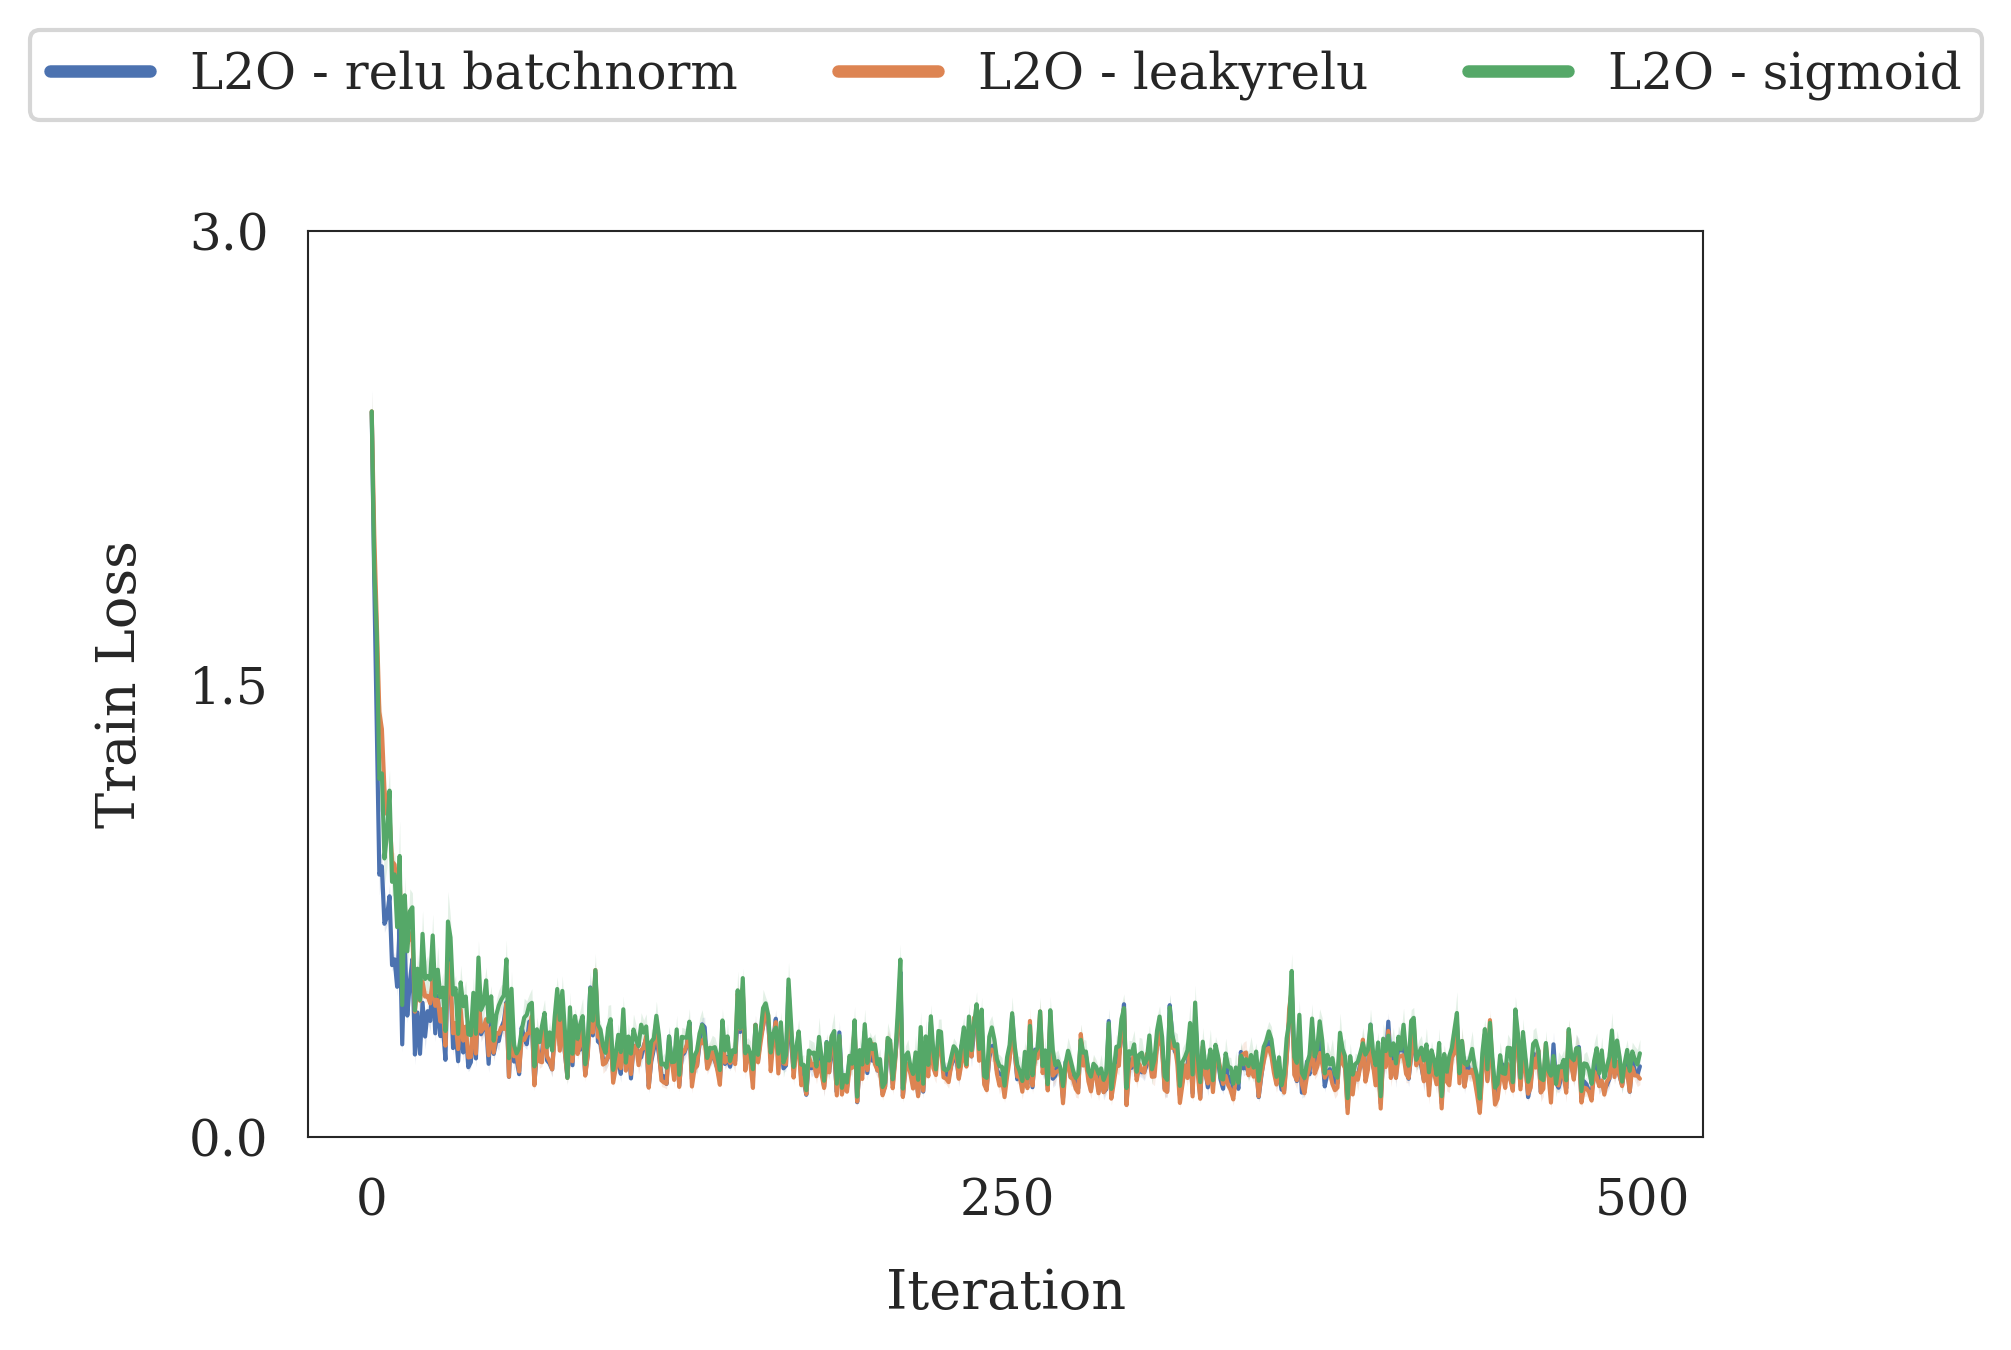

In [24]:
plot_performance(
    run_nickname=run_nickname,
    show_max_iters=show_max_iters,
    # log_loss=log_loss,
    log_loss=False,
    save_fig_to_path=save_fig_to_path,
    with_err_bars=True,
    conv_window=1,
)

## Params, Grads, Updates
Plot the norm and mean abs value of parameters, gradients, and parameter updates across training

In [103]:
### collect
### baseline optimizers
for baseline_name in baselines.keys():
    baselines[baseline_name]["params_grads"] = {k: {} for k in ["param_norms", "param_abs_means", "grad_norms", "grad_abs_means", "updates_norms", "updates_abs_means"]}
    opter_metrics = baselines[baseline_name]["metrics"]
    config = baselines[baseline_name]["config"]

    for iter_i in range(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"]):
        ckpt_dir = os.path.join(os.environ["CKPT_PATH"], "baselines", baselines[baseline_name]["baseline_dir"], "ckpt")
        optee, opter, optee_grads, loss_history = load_baseline_opter_ckpt(
            path=os.path.join(ckpt_dir, f"run0_{iter_i}.pt"),
            optee_cls=config["meta_testing"]["optee_cls"],
            opter_cls=config["baseline_opter_cls"],
            optee_config=config["meta_testing"]["optee_config"],
            opter_config=config["meta_testing"]["baseline_opter_config"]
        )
        optee_updates = get_baseline_opter_param_updates(optee, opter)
    
        for n, p in optee.all_named_parameters():
            if not p.requires_grad:
                continue
            for k in baselines[baseline_name]["params_grads"]:
                if n not in baselines[baseline_name]["params_grads"][k]:
                    baselines[baseline_name]["params_grads"][k][n] = []
            baselines[baseline_name]["params_grads"]["param_norms"][n].append(p.norm().item())
            baselines[baseline_name]["params_grads"]["param_abs_means"][n].append(p.abs().mean().item())
            baselines[baseline_name]["params_grads"]["grad_norms"][n].append(p.grad.norm().item())
            baselines[baseline_name]["params_grads"]["grad_abs_means"][n].append(p.grad.abs().mean().item())
            baselines[baseline_name]["params_grads"]["updates_norms"][n].append(optee_updates[n].norm().item())
            baselines[baseline_name]["params_grads"]["updates_abs_means"][n].append(optee_updates[n].abs().mean().item())

### l2o optimizers
for l2o_name in l2os:
    config = l2os[l2o_name]["config"]
    l2os[l2o_name]["params_grads"] = {k: {} for k in ["param_norms", "param_abs_means", "grad_norms", "grad_abs_means", "updates_norms", "updates_abs_means"]}
    
    for iter_i in range(config["meta_testing"]["ckpt_iter_freq"], config["meta_testing"]["n_iters"] + 1, config["meta_testing"]["ckpt_iter_freq"]):
        # load L2O optimizer
        optee, opter, optee_grads, optee_updates, loss_history = load_l2o_opter_ckpt(
            path=os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"], f"{iter_i}.pt"),
            optee_cls=config["meta_testing"]["optee_cls"],
            opter_cls=config["opter_cls"],
            optee_config=config["meta_testing"]["optee_config"],
            opter_config=config["opter_config"],
        )
        # scale updates by optee update lr
        optee_updates = {n: p * config["meta_testing"]["optee_updates_lr"] for n, p in optee_updates.items()}

        for n, p in optee.all_named_parameters():
            if not p.requires_grad:
                continue
            for k in l2os[l2o_name]["params_grads"]:
                if n not in l2os[l2o_name]["params_grads"][k]:
                    l2os[l2o_name]["params_grads"][k][n] = []
            l2os[l2o_name]["params_grads"]["param_norms"][n].append(p.norm().item())
            l2os[l2o_name]["params_grads"]["param_abs_means"][n].append(p.abs().mean().item())
            l2os[l2o_name]["params_grads"]["grad_norms"][n].append(p.grad.norm().item())
            l2os[l2o_name]["params_grads"]["grad_abs_means"][n].append(p.grad.abs().mean().item())
            l2os[l2o_name]["params_grads"]["updates_norms"][n].append(optee_updates[n].norm().item())
            l2os[l2o_name]["params_grads"]["updates_abs_means"][n].append(optee_updates[n].abs().mean().item())

In [ ]:
k = "grad_norms"
max_len = 500

fig = plt.figure(figsize=(22, 20))
x_ticks = np.arange(5, max_len + 1, 5)

def smooth(y, box_pts=10):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode="same")
    return y_smooth

for i, n in enumerate(baselines["SGD"]["params_grads"][k]):
    ax = fig.add_subplot(3, 2, i + 1)

    for baseline_name, baseline_dict in baselines.items():
        if n not in baseline_dict["params_grads"][k]:
            continue
        sns.lineplot(x=x_ticks, y=smooth(baseline_dict["params_grads"][k][n][:max_len]), alpha=0.8, linewidth=1.5, linestyle="--", ax=ax, label=f"{baseline_name}")
    for l2o_name, l2o_dict in l2os.items():
        if n not in l2o_dict["params_grads"][k]:
            continue
        sns.lineplot(x=x_ticks, y=smooth(l2o_dict["params_grads"][k][n][:max_len]), alpha=0.8, linewidth=1.5, ax=ax, label=f"{l2o_name}")

    ax.set_xlabel("Iteration")
    ax.set_title(k.replace("_", " ").title() + ": " + n, fontsize=13, fontweight="bold")
    ax.legend()

plt.show()

### save the figure
fig.savefig(os.path.join(f"params_grads_updates_{k}.png"))

## Conservation Law Breaking

In [ ]:
phase = "meta_testing"
max_iters = 500
reg_func = regularize_translation_conservation_law_breaking

### collect deviations
for l2o_name in l2os:
    config = l2os[l2o_name]["config"]
    l2os[l2o_name][reg_func.__name__] = np.array(collect_conservation_law_deviations(
        func=reg_func,
        opter_cls=Optimizer,
        opter_config=config["opter_config"],
        optee_cls=config["meta_testing"]["optee_cls"],
        optee_config=config["meta_testing"]["optee_config"],
        ckpt_iter_freq=config["meta_testing"]["ckpt_iter_freq"],
        n_iters=config["meta_testing"]["n_iters"],
        ckpt_path_prefix=os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"], ""),
        is_l2o=True,
        max_iters=max_iters,
    ))

### Baseline optimizers
for baseline_name in baselines:
    if "baseline_opter_cls" in baselines[baseline_name]["config"]:
        baseline_opter_cls = baselines[baseline_name]["config"]["baseline_opter_cls"]
    elif "sgd" in baseline_name.lower():
        baseline_opter_cls = optim.SGD
    elif "adam" in baseline_name.lower():
        baseline_opter_cls = optim.Adam
    else:
        raise NotImplementedError
    config = baselines[baseline_name]["baseline_config"]
    baseline_opter_config = config["opter_config"]
    ### collect deviations
    baselines[baseline_name][reg_func.__name__] = np.array(collect_conservation_law_deviations(
        func=reg_func,
        opter_cls=baseline_opter_cls,
        opter_config=baseline_opter_config,
        optee_cls=config["meta_testing"]["optee_cls"],
        optee_config=baselines[baseline_name]["config"]["meta_testing"]["optee_config"],
        ckpt_iter_freq=baselines[baseline_name]["config"]["meta_testing"]["ckpt_iter_freq"],
        n_iters=baselines[baseline_name]["config"]["meta_testing"]["n_iters"],
        ckpt_path_prefix=os.path.join(os.environ["CKPT_PATH"], baselines[baseline_name]["baseline_dir"], "ckpt/"),
        is_l2o=False,
        max_iters=max_iters,
    ))

## Breaking Geometric Constraints on Gradients

In [ ]:
phase = "meta_testing"
max_iters = None
collect_func = collect_translation_sym_deviations

### L2O optimizers
for l2o_name in l2os:
    config = l2os[l2o_name]["config"]
    l2os[l2o_name][collect_func.__name__ + "_grads"] = []
    l2os[l2o_name][collect_func.__name__ + "_updates"] = []
    for test_run_i in range(config["eval_n_tests"]):
        grad_deviations, param_update_deviations = collect_func(
            ckpt_iter_freq=config["meta_testing"]["ckpt_iter_freq"],
            n_iters=config["meta_testing"]["n_iters"],
            optee_cls=config["meta_testing"]["optee_cls"],
            opter_cls=config["opter_cls"],
            optee_config=config["meta_testing"]["optee_config"],
            opter_config=config["opter_config"],
            phase="meta_testing",
            ckpt_path_prefix=os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"], f"run{test_run_i}_"),
            max_iters=max_iters,
        )
        if np.ndim(grad_deviations) == 2:
            ### sum the deviations (weight and bias)
            grad_deviations = grad_deviations.sum(-1)
            param_update_deviations = param_update_deviations.sum(-1)
        l2os[l2o_name][collect_func.__name__ + "_grads"].append(grad_deviations)
        l2os[l2o_name][collect_func.__name__ + "_updates"].append(param_update_deviations)

### Baseline optimizers
for baseline_name in baselines:
    if "baseline_opter_cls" in baselines[baseline_name]["config"]:
        baseline_opter_cls = baselines[baseline_name]["config"]["baseline_opter_cls"]
    elif "sgd" in baseline_name.lower():
        baseline_opter_cls = optim.SGD
    elif "adam" in baseline_name.lower():
        baseline_opter_cls = optim.Adam
    else:
        raise NotImplementedError
    config = baselines[baseline_name]["config"]
    baseline_opter_config = baselines[baseline_name]["config"]["meta_testing"]["baseline_opter_config"]
    
    ### collect deviations
    baselines[baseline_name][collect_func.__name__ + "_grads"] = []
    baselines[baseline_name][collect_func.__name__ + "_updates"] = []
    for test_run_i in range(config["eval_n_tests"]):
        grad_deviations, param_update_deviations = collect_func(
            ckpt_iter_freq=config["meta_testing"]["ckpt_iter_freq"],
            n_iters=config["meta_testing"]["n_iters"],
            optee_cls=config["meta_testing"]["optee_cls"],
            optee_config=config["meta_testing"]["optee_config"],
            opter_cls=baseline_opter_cls,
            opter_config=baseline_opter_config,
            phase="meta_testing",
            ckpt_path_prefix=os.path.join(baselines[baseline_name]["baseline_dir"], f"ckpt/run{test_run_i}_"),
            max_iters=max_iters,
        )
        if np.ndim(grad_deviations) == 2:
            ### sum the deviations (weight and bias)
            grad_deviations = grad_deviations.sum(-1)
            param_update_deviations =  param_update_deviations.sum(-1)
        baselines[baseline_name][collect_func.__name__ + "_grads"].append(grad_deviations)
        baselines[baseline_name][collect_func.__name__ + "_updates"].append(param_update_deviations)

## Plotting - Deviations

In [ ]:
def plot_deviations(dict_key_to_plot, log=False, abs_values=False, max_iters=None, save_fig_to_path=None):
    ### plot comparison
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_ticks = np.arange(
        0,
        min(max_iters + 1, config["meta_testing"]["n_iters"] + 1) if max_iters != None else config["meta_testing"]["n_iters"] + 1,
        config["meta_testing"]["ckpt_iter_freq"]
    )

    ### L2O optimizers
    for l2o_name, l2o_dict in l2os.items():
        to_plot = np.array(
            l2o_dict[dict_key_to_plot] if not abs_values else np.abs(l2o_dict[dict_key_to_plot])
        )[:, :len(x_ticks)]
        sns.lineplot(
            x=x_ticks,
            y=to_plot.mean(0),
            label=l2o_name,
            ax=ax,
        )
        ax.fill_between(
            x=x_ticks,
            y1=to_plot.mean(0) - to_plot.std(0),
            y2=to_plot.mean(0) + to_plot.std(0),
            alpha=0.2,
        )

    ### baseline optimizers
    for baseline_name, baseline_dict in baselines.items():
        to_plot = np.array(
            baseline_dict[dict_key_to_plot] if not abs_values else np.abs(baseline_dict[dict_key_to_plot])
        )[:, :len(x_ticks)]
        sns.lineplot(
            x=x_ticks,
            y=to_plot.mean(0),
            label=baseline_name,
            linestyle="--",
            linewidth=1.5,
            ax=ax,
        )
        ax.fill_between(
            x=x_ticks,
            y1=to_plot.mean(0) - to_plot.std(0),
            y2=to_plot.mean(0) + to_plot.std(0),
            alpha=0.2,
        )

    ### plot settings
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Deviation" if not abs_values else "Absolute Deviation")

    # set y to log scale
    if log:
        ax.set_yscale("log")

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
    ax.legend(loc="upper right")
    legend = ax.get_legend()
    for legend_handle in legend.legendHandles:
        legend_handle.set_linewidth(3.0)

    # x-ticks
    x_ticks = ax.get_xticks()
    x_ticks = np.linspace(0, max_iters, 3)
    ax.set_xticks(x_ticks)
    
    # y-ticks
    # y_max = ax.get_ylim()[1]
    # y_max = np.ceil(y_max / 100) * 100 # round
    # y_ticks = np.linspace(0, y_max, 4)
    # ax.set_yticks(y_ticks)
    # y_ticks = ax.get_yticks()
    # ax.set_yticks(y_ticks[::3])
    # ax.set_ylim(0, 90)
    # ax.set_yticks([0, 45, 90])

    plt.show()

    ### save the figure
    if save_fig_to_path is not None:
        fig.savefig(save_fig_to_path, bbox_inches="tight")

In [ ]:
key_to_plot = collect_func.__name__ + "_updates"
# key_to_plot = reg_func.__name__
save_fig_to_path = os.path.join(
    "..",
    "results",
    "publication",
    "constraint_deviations",
    "translation_sym_meta_testing_MNISTNet_{}_200.pdf"
)
save_fig_to_path = None

plot_deviations(
    key_to_plot,
    log=False,
    abs_values=True,
    max_iters=200,
    save_fig_to_path=save_fig_to_path,
)

## Heavy-tail gradient/update noise

In [55]:
def eval_metrics(optee, data_loader, l2o_opter=None, hidden_states=None, cell_states=None):
    ### calculate gradient (and update) noise over the the given data loader
    optee.eval()
    tmp_optee_optim = optim.SGD(optee.parameters(), lr=0.0) # just for zeroing out the gradients
    grads = []
    l2o_updates = []
    losses = []
    accs = []
    n_minibatches = 0
    for i, (x, y) in enumerate(data_loader):
        n_minibatches += 1
        tmp_optee_optim.zero_grad()
        
        x, y = x.view(-1, 784).cuda(), y.cuda()
        loss, acc = optee(inp=x, out=y, return_acc=True)
        loss.backward()

        ### collect gradients
        grads.append(torch.cat([p.grad.detach().view(-1) for n, p in optee.all_named_parameters() if p.requires_grad]).cpu())

        ### collect l2o updates
        if l2o_opter is not None:
            curr_l2o_updates = []
            offset = 0
            for name, p in optee.all_named_parameters():
                if p.requires_grad == False: # batchnorm stats
                    continue

                cur_sz = int(np.prod(p.size()))
                gradients = p.grad.detach().view(cur_sz, 1)
                updates, _, _ = l2o_opter(
                    optee_grads=gradients,
                    hidden=[h[offset : offset + cur_sz] for h in hidden_states],
                    cell=[c[offset : offset + cur_sz] for c in cell_states],
                    additional_inp=None,
                )
                offset += cur_sz
                curr_l2o_updates.append(updates.detach().view(-1))
            l2o_updates.append(torch.cat(curr_l2o_updates).cpu())

        ### track history
        losses.append(loss.item())
        accs.append(acc.item())

    optee_total_params = len(grads[0])

    ### gradients
    grads = torch.stack(grads, dim=0) # (n_minibatches, optee_total_params)
    mean_grad = grads.mean(dim=0) # (optee_total_params,)
    grads_noise_norm = (grads - mean_grad).norm(dim=1) # (n_minibatches,)
    # get the tail index alpha
    N = optee_total_params * n_minibatches
    for i in range(1, 1 + int(np.sqrt(N))):
        if N % i == 0:
            m = i
    grads_alpha = alpha_estimator(m, (grads - mean_grad).view(-1, 1))

    ### l2o updates
    l2o_updates_noise_norm, l2o_updates_alpha = None, None
    if l2o_opter is not None:
        l2o_updates = torch.stack(l2o_updates, dim=0) # (n_minibatches, optee_total_params)
        mean_l2o_updates = l2o_updates.mean(dim=0) # (optee_total_params,)
        l2o_updates_noise_norm = (l2o_updates - mean_l2o_updates).norm(dim=1) # (n_minibatches,)
        # get the tail index alpha
        N = optee_total_params * n_minibatches
        for i in range(1, 1 + int(np.sqrt(N))):
            if N % i == 0:
                m = i
        l2o_updates_alpha = alpha_estimator(m, (l2o_updates - mean_l2o_updates).view(-1, 1))

    return (
        losses,
        accs,
        grads_noise_norm,
        grads_alpha,
        l2o_updates_noise_norm,
        l2o_updates_alpha,
    )

In [56]:
def collect_grad_update_noise_for_l2o(ckpt_path, run_history, config, train_data, test_data):
    ckpt = torch.load(ckpt_path)
    optee = config["meta_testing"]["optee_cls"](**config["meta_testing"]["optee_config"]).cuda()
    optee.load_state_dict(ckpt["optimizee"])

    ### init l2o optimizer to collect noise in its updates
    opter = config["opter_cls"](**config["opter_config"]).cuda()
    opter.load_state_dict(ckpt["optimizer"])

    ### collect history
    for phase, data_loader in (("train", train_data.loader), ("test", test_data.loader)):
        losses, accs, grads_noise_norm, grads_alpha, l2o_updates_noise_norm, l2o_updates_alpha = eval_metrics(
            optee=optee,
            data_loader=data_loader,
            l2o_opter=opter,
            hidden_states=ckpt["hidden_states"],
            cell_states=ckpt["cell_states"]
        )
        run_history[phase]["loss"].append(np.mean(losses))
        run_history[phase]["acc"].append(np.mean(accs))
        run_history[phase]["grads_noise_norm"].append(grads_noise_norm)
        run_history[phase]["grads_alpha"].append(grads_alpha.item())
        run_history[phase]["l2o_updates_noise_norm"].append(l2o_updates_noise_norm)
        run_history[phase]["l2o_updates_alpha"].append(l2o_updates_alpha.item())
    
    return run_history

In [57]:
load_existing = True

### collect for L2Os
for opter_name in l2os:
    print(f"Running {opter_name}...")
    config = l2os[opter_name]["config"]
    ckpts_dir = os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"])
    save_run_history_path = os.path.join(
        os.environ["CKPT_PATH"],
        config["ckpt_base_dir"],
        f"grads_updates_noise_heavy_tail_alpha_estimates" +
            f"_{config['meta_testing']['optee_cls'].__name__}_{dict_to_str(config['meta_testing']['optee_config'])}" +
            f"_{config['meta_testing']['data_cls'].__name__}_{dict_to_str(config['meta_testing']['data_config'])}" +
            f"_{config['eval_n_tests']}_tests.pt"
    )

    if load_existing and os.path.exists(save_run_history_path):
        print(f"  Loading existing run history from {save_run_history_path}")
        run_history = torch.load(save_run_history_path)
        l2os[opter_name]["run_history"] = run_history
        continue

    run_history_all_test_runs = []
    for test_run_i in range(config["eval_n_tests"]):
        print(f"  Test run {test_run_i}...")
        ckpt_prefix = f"run{test_run_i}_"
    
        ### collect
        run_history = {k: {k: [] for k in ("loss", "acc", "grads_noise_norm", "grads_alpha", "l2o_updates_noise_norm", "l2o_updates_alpha")}
            for k in ("train", "test")}
        train_data = MNIST(training=True, batch_size=128)
        test_data = MNIST(training=False, batch_size=128)

        ### the very first checkpoint
        print(f"  [{1}/{config['meta_testing']['n_iters']}]")
        ckpt_path = os.path.join(ckpts_dir, f"{ckpt_prefix}1.pt")
        if os.path.exists(ckpt_path):
            run_history = collect_grad_update_noise_for_l2o(
                ckpt_path=ckpt_path,
                run_history=run_history,
                config=config,
                train_data=train_data,
                test_data=test_data
            )
        else:
            print(f"  {ckpt_path} does not exist, skipping.")

        ### the rest of the checkpoints
        for iter_i in range(
            config["meta_testing"]["ckpt_iter_freq"],
            config["meta_testing"]["n_iters"] + 1,
            config["meta_testing"]["ckpt_iter_freq"],
        ):
            print(f"  [{iter_i}/{config['meta_testing']['n_iters']}]")

            ### load checkpoint
            ckpt_path = os.path.join(ckpts_dir, f"{ckpt_prefix}{iter_i}.pt")
            run_history = collect_grad_update_noise_for_l2o(
                ckpt_path=ckpt_path,
                run_history=run_history,
                config=config,
                train_data=train_data,
                test_data=test_data
            )

        ### save current test run
        run_history_all_test_runs.append(run_history)

    ### save
    l2os[opter_name]["run_history"] = run_history_all_test_runs
    torch.save(run_history_all_test_runs, save_run_history_path)

Running L2O - unroll 20...
  Loading existing run history from /media/jsobotka/Data/Dev/l2o/ckpt/12-05-2023_00-38-54_MNISTReluBatchNorm_Optimizer/grads_updates_noise_heavy_tail_alpha_estimates_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=128}_5_tests.pt


In [58]:
def collect_grad_noise_for_normal(ckpt_path, run_history, config, train_data, test_data):
    ckpt = torch.load(ckpt_path)
    optee = config["meta_testing"]["optee_cls"](**config["meta_testing"]["optee_config"]).cuda()
    optee.load_state_dict(ckpt["optimizee"])

    ### collect
    for phase, data_loader in (("train", train_data.loader), ("test", test_data.loader)):
        losses, accs, grads_noise_norm, grads_alpha, _, _ = eval_metrics(
            optee=optee,
            data_loader=data_loader,
            l2o_opter=None,
            hidden_states=None,
            cell_states=None
        )
        run_history[phase]["loss"].append(np.mean(losses))
        run_history[phase]["acc"].append(np.mean(accs))
        run_history[phase]["grads_noise_norm"].append(grads_noise_norm)
        run_history[phase]["grads_alpha"].append(grads_alpha.item())

    return run_history

In [59]:
load_existing = True

### collect for baselines
for baseline_name in baselines:
    print(f"Running {baseline_name}...")
    config = baselines[baseline_name]["config"]
    save_run_history_path = os.path.join(
        baselines[baseline_name]["baseline_dir"],
        f"grad_noise_run_history_{config['eval_n_tests']}_tests.pt"
    )

    if load_existing and os.path.exists(save_run_history_path):
        print(f"  Loading existing run history from {save_run_history_path}")
        run_history = torch.load(save_run_history_path)
        baselines[baseline_name]["run_history"] = run_history
        continue
    
    run_history_all_test_runs = []
    for test_run_i in range(config["eval_n_tests"]):
        print(f"  Test run {test_run_i}...")
        ckpt_prefix = f"run{test_run_i}_"
        ### collect
        run_history = {k: {k: [] for k in ("loss", "acc", "grads_noise_norm", "grads_alpha", "l2o_updates_noise_norm", "l2o_updates_alpha")}
            for k in ("train", "test")}
        train_data = MNIST(training=True, batch_size=128)
        test_data = MNIST(training=False, batch_size=128)

        ### the very first checkpoint
        print(f"  [{1}/{config['meta_testing']['n_iters']}]")
        ckpt_path = os.path.join(baselines[baseline_name]["baseline_dir"], "ckpt", f"{ckpt_prefix}1.pt")
        if os.path.exists(ckpt_path):
            run_history = collect_grad_noise_for_normal(
                ckpt_path=ckpt_path,
                run_history=run_history,
                config=config,
                train_data=train_data,
                test_data=test_data
            )
        else:
            print(f"  {ckpt_path} does not exist, skipping.")

        ### the rest of the checkpoints
        for iter_i in range(
            config["meta_testing"]["ckpt_iter_freq"],
            config["meta_testing"]["n_iters"] + 1,
            config["meta_testing"]["ckpt_iter_freq"],
        ):
            print(f"  [{iter_i}/{config['meta_testing']['n_iters']}]")
            
            ### load checkpoint
            ckpt_path = os.path.join(baselines[baseline_name]["baseline_dir"], "ckpt", f"{ckpt_prefix}{iter_i}.pt")
            run_history = collect_grad_noise_for_normal(
                ckpt_path=ckpt_path,
                run_history=run_history,
                config=config,
                train_data=train_data,
                test_data=test_data
            )
        
        ### save current test run
        run_history_all_test_runs.append(run_history)

    ### save
    baselines[baseline_name]["run_history"] = run_history_all_test_runs
    torch.save(run_history_all_test_runs, save_run_history_path)

Running Adam...
  Loading existing run history from /media/jsobotka/Data/Dev/l2o/ckpt/baselines/Adam_{lr=find_best_lr_normal}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=128}/grad_noise_run_history_3_tests.pt
Running SGD...
  Loading existing run history from /media/jsobotka/Data/Dev/l2o/ckpt/baselines/SGD_{lr=find_best_lr_normal_momentum=0.9}_MNISTReluBatchNorm_{affine=True_track_running_stats=True}_MNIST_{batch_size=128}/grad_noise_run_history_3_tests.pt


In [60]:
### preprocess
### turn l2os[opter_name]["run_history"][<number-of-test>]["train"][<metric>] into l2os[opter_name]["run_history"]["train"][<metric>][<number-of-test>]
for opter_name in l2os:
    new_train_run_history = dict()
    new_test_run_history = dict()
    for test_run_i in range(l2os[opter_name]["config"]["eval_n_tests"]):
        for metric_name in l2os[opter_name]["run_history"][test_run_i]["train"]:
            if test_run_i == 0:
                new_train_run_history[metric_name] = [l2os[opter_name]["run_history"][test_run_i]["train"][metric_name]]
                new_test_run_history[metric_name] = [l2os[opter_name]["run_history"][test_run_i]["test"][metric_name]]
            else:
                new_train_run_history[metric_name].append(l2os[opter_name]["run_history"][test_run_i]["train"][metric_name])
                new_test_run_history[metric_name].append(l2os[opter_name]["run_history"][test_run_i]["test"][metric_name])
    l2os[opter_name]["run_history"] = dict()
    l2os[opter_name]["run_history"]["train"] = new_train_run_history
    l2os[opter_name]["run_history"]["test"] = new_test_run_history

for baseline_name in baselines:
    new_train_run_history = dict()
    new_test_run_history = dict()
    for test_run_i in range(baselines[baseline_name]["config"]["eval_n_tests"]):
        for metric_name in baselines[baseline_name]["run_history"][test_run_i]["train"]:
            if test_run_i == 0:
                new_train_run_history[metric_name] = [baselines[baseline_name]["run_history"][test_run_i]["train"][metric_name]]
                new_test_run_history[metric_name] = [baselines[baseline_name]["run_history"][test_run_i]["test"][metric_name]]
            else:
                new_train_run_history[metric_name].append(baselines[baseline_name]["run_history"][test_run_i]["train"][metric_name])
                new_test_run_history[metric_name].append(baselines[baseline_name]["run_history"][test_run_i]["test"][metric_name])
    baselines[baseline_name]["run_history"] = dict()
    baselines[baseline_name]["run_history"]["train"] = new_train_run_history
    baselines[baseline_name]["run_history"]["test"] = new_test_run_history

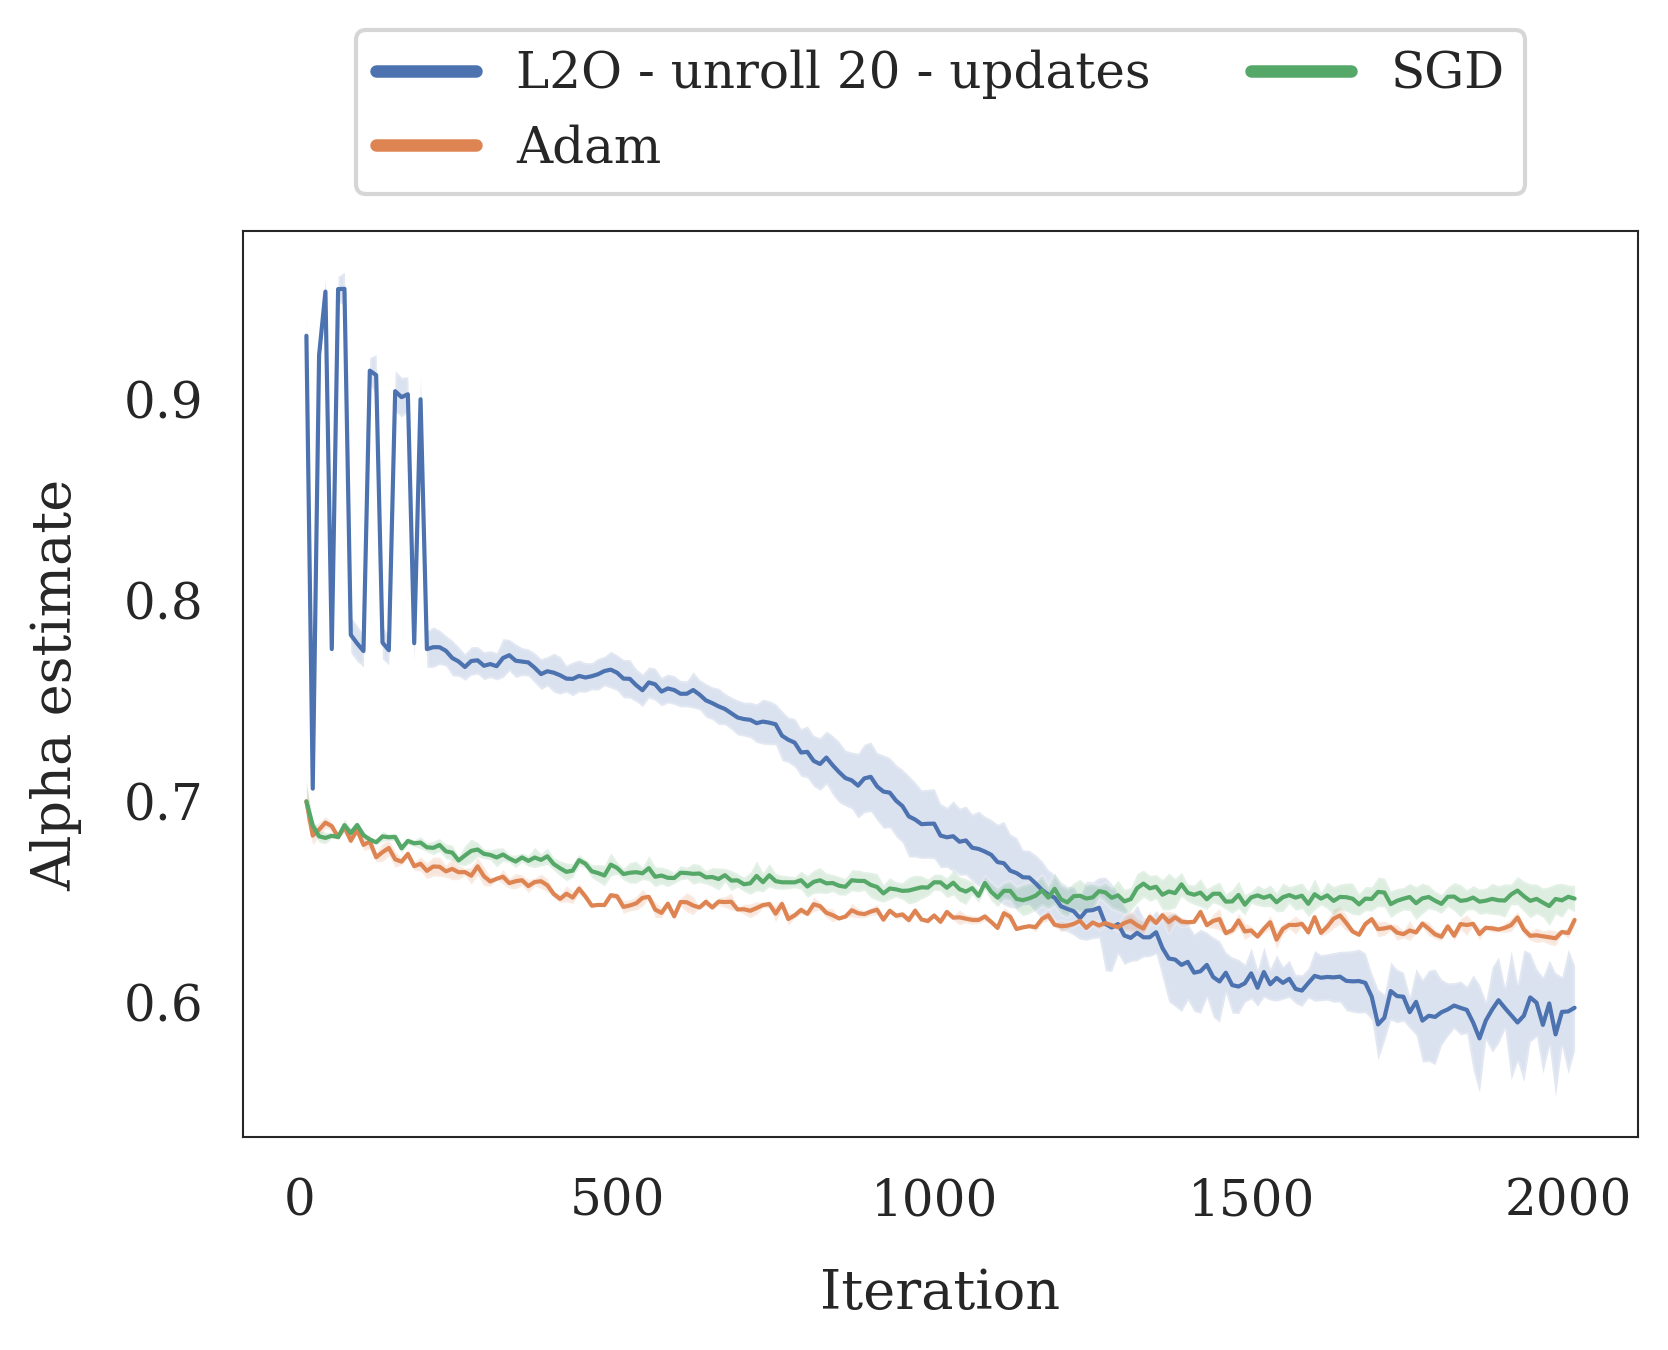

In [61]:
max_iters = 2000
plot_l2o_grad_alpha = False
plot_l2o_update_alpha = True
optee_name = "MNISTNet"
phase = "train"
save_fig_to_path = os.path.join(
    "../results/heavy_tail_grad_update_noise",
    f"update_noise_alpha_estimates_{optee_name}_{phase}.pdf" if max_iters is None \
        else f"update_noise_alpha_estimates_{optee_name}_{phase}_{max_iters}_iters.pdf"
)
save_fig_to_path = None

x_ticks = range(
    config["meta_testing"]["ckpt_iter_freq"],
    config["meta_testing"]["n_iters"] + config["meta_testing"]["ckpt_iter_freq"] + 1 \
        if max_iters is None or config["meta_testing"]["n_iters"] <= max_iters \
        else max_iters + 1,
    config["meta_testing"]["ckpt_iter_freq"]
)

### plot alpha estimates
fig = plt.figure()
ax = fig.add_subplot(111)

for opter_name in l2os:
    if plot_l2o_grad_alpha:
        ### alpha estimates for gradients
        grads_alpha = np.array(l2os[opter_name]["run_history"][phase]["grads_alpha"])[:, :len(x_ticks)] # (n_tests, n_iters)
        sns.lineplot(x=x_ticks, y=grads_alpha.mean(0), label=f"{opter_name} - gradients", ax=ax)
        ax.fill_between(
            x=x_ticks,
            y1=grads_alpha.mean(0) - grads_alpha.std(0),
            y2=grads_alpha.mean(0) + grads_alpha.std(0),
            alpha=0.2
        )

    if plot_l2o_update_alpha:
        ### alpha estimates for param updates
        updates_alpha = np.array(l2os[opter_name]["run_history"][phase]["l2o_updates_alpha"])[:, :len(x_ticks)] # (n_tests, n_iters)
        sns.lineplot(x=x_ticks, y=updates_alpha.mean(0), label=f"{opter_name} - updates", ax=ax)
        ax.fill_between(
            x=x_ticks,
            y1=updates_alpha.mean(0) - updates_alpha.std(0),
            y2=updates_alpha.mean(0) + updates_alpha.std(0),
            alpha=0.2
        )

for baseline_name in baselines:
    grads_alpha = np.array(baselines[baseline_name]["run_history"][phase]["grads_alpha"])[:, :len(x_ticks)] # (n_tests, n_iters)
    sns.lineplot(x=x_ticks, y=grads_alpha.mean(0), label=baseline_name, ax=ax)
    ax.fill_between(
        x=x_ticks,
        y1=grads_alpha.mean(0) - grads_alpha.std(0),
        y2=grads_alpha.mean(0) + grads_alpha.std(0),
        alpha=0.2
    )

# ax.set_title(f"Alpha estimates ({phase})")
ax.set_xlabel("Iteration")
ax.set_ylabel("Alpha estimate")


### manual
# ax.set_ylim(0.5, 1.)
# yticks = ax.get_yticks()
# ax.set_yticks(yticks[::3])
# ax.set_yticks([0.5, 0.65, 0.8, 1])
ax.set_xticks(np.arange(0, 1001 if max_iters is None else max_iters + 1, 500))

# legend
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.25), ncol=2)
legend = ax.get_legend()
for legend_handle in legend.legendHandles:
    legend_handle.set_linewidth(3.0)

plt.show()

# save fig
if save_fig_to_path:
    fig.savefig(save_fig_to_path, bbox_inches="tight")

### Validating results from the paper

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self, input_dim=28*28 , width=50, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim 
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        
        layers = self.get_layers()

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):
        layers = []
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        x = x.view(x.size(0), self.input_dim)
        x = self.fc(x)
        return x

In [ ]:
def get_data():
    from torchvision import datasets, transforms
    data_class = 'MNIST'
    num_classes = 10
    stats = {
        'mean': [0.1307], 
        'std': [0.3081]
        }

    # input transformation w/o preprocessing for now

    trans = [
        transforms.ToTensor(),
        lambda t: t.type(torch.get_default_dtype()),
        transforms.Normalize(**stats)
        ]
        
    # get tr and te data with the same normalization
    tr_data = getattr(datasets, data_class)(
        root=os.environ['DATA_PATH'], 
        train=True, 
        download=False,
        transform=transforms.Compose(trans)
        )

    te_data = getattr(datasets, data_class)(
        root=os.environ['DATA_PATH'], 
        train=False, 
        download=False,
        transform=transforms.Compose(trans)
        )

    # get tr_loader for train/eval and te_loader for eval
    train_loader = torch.utils.data.DataLoader(
        dataset=tr_data,
        batch_size=100, 
        shuffle=False,
        )

    train_loader_eval = torch.utils.data.DataLoader(
        dataset=tr_data,
        batch_size=100, 
        shuffle=False,
        )

    test_loader_eval = torch.utils.data.DataLoader(
        dataset=te_data,
        batch_size=100, 
        shuffle=False,
        )

    return train_loader, test_loader_eval, train_loader_eval, num_classes

In [ ]:
### run separately
run_history = {k: [] for k in ("train_loss", "train_acc", "noise_norm", "alpha")}
# train_data = MNIST(training=True, batch_size=100)
# test_data = MNIST(training=False, batch_size=100)
train_loader, test_loader_eval, train_loader_eval, num_classes = get_data()

# optee = MNISTRelu().cuda()
optee = FullyConnected(width=20, depth=1).cuda()
optee_optim = optim.SGD(optee.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

def eval():
    optee.eval()
    grads = []
    losses = []
    accs = []
    n_minibatches = 0
    # for data in (train_data,):
    for i, (x, y) in enumerate(train_loader_eval):
        n_minibatches += 1
        
        x, y = x.view(-1, 784).cuda(), y.cuda()
        # loss, acc = optee(x, out=y, return_acc=True)
        y_hat = optee(x)
        loss = loss_fn(y_hat, y)
        loss.backward()

        ### collect gradients
        # grads.append(torch.cat([p.grad.detach().view(-1) for n, p in optee.all_named_parameters() if p.requires_grad]).cpu())
        grads.append(torch.cat([p.grad.detach().view(-1) for n, p in optee.named_parameters() if p.requires_grad]).cpu())

        ### track history
        losses.append(loss.item())
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        accs.append(acc.item())
        
        optee_optim.zero_grad()

    optee_total_params = len(grads[0])
    grads = torch.stack(grads, dim=0) # (n_minibatches, optee_total_params)
    mean_grad = grads.mean(dim=0) # (optee_total_params,)
    noise_norm = (grads - mean_grad).norm(dim=1) # (n_minibatches,)

    ### get the tail index alpha
    N = optee_total_params * n_minibatches
    for i in range(1, 1 + int(np.sqrt(N))):
        if N % i == 0:
            m = i
    alpha = alpha_estimator(m, (grads - mean_grad).view(-1, 1))

    ### collect history
    run_history["train_loss"].append(np.mean(losses))
    run_history["train_acc"].append(np.mean(accs))
    run_history["noise_norm"].append(noise_norm)
    run_history["alpha"].append(alpha.item())

def cyclic_loader(loader):
    while True:
        for x in loader:
            yield x

cyclic_train_loader = cyclic_loader(train_loader)

for i, (x, y) in enumerate(cyclic_train_loader):
    if i % 100 == 0:
        eval()
        print(i, run_history["train_loss"][-1], run_history["train_acc"][-1], run_history["alpha"][-1])
    
    optee.train()
    x, y = x.view(-1, 784).cuda(), y.cuda()
    # loss, acc = optee(inp=x, out=y, return_acc=True)
    y_hat = optee(x)
    loss = loss_fn(y_hat, y)
    loss.backward()
    optee_optim.step()
    optee_optim.zero_grad()



In [ ]:
fig = plt.figure()
plt.plot(run_history["train_loss"])
plt.show()

fig = plt.figure()
plt.plot(run_history["train_acc"])
plt.show()

fig = plt.figure()
plt.plot(run_history["alpha"])
plt.show()

## Heavy-tail distribution of parameters

In [ ]:
def get_sampling_ms(N):
    ms = [2]
    select_ms_closest_to_curr_idx = 0
    select_ms_closest_to = [5, 10, 20, 50, 100, 500, 1000]
    for i in range(3, 1 + int(np.sqrt(N))):
        if N % i == 0 \
            and i > ms[-1] \
            and ms[-1] < select_ms_closest_to[select_ms_closest_to_curr_idx] \
            and i >= select_ms_closest_to[select_ms_closest_to_curr_idx]:
            ms.append(i)
            select_ms_closest_to_curr_idx += 1
            if select_ms_closest_to_curr_idx >= len(select_ms_closest_to):
                break
    return ms

In [ ]:
def collect_parameter_heavy_tail_alpha_estimates(
    config,
    ckpts_dir,
    iters_window,
    ckpt_iter_freq,
    iter_print_freq=50,
):
    ### collect
    parameter_history_metrics = {k: [] for k in ("loss", "acc", "params_alpha_total")}
    for k in ("params_noise_norm_per_iter", "params_alpha_per_iter"):
        parameter_history_metrics[k] = dict()
    
    _tmp_optee = config["meta_testing"]["optee_cls"](**config["meta_testing"]["optee_config"])
    params = {iter_i: {n: [] for n, p in _tmp_optee.named_parameters() if p.requires_grad}
        for iter_i in range(iters_window[0], iters_window[1], ckpt_iter_freq)}
    del _tmp_optee

    for test_run_i in range(config["eval_n_tests"]):
        print(f"  Test run {test_run_i}...")
        for iter_i in range(
            iters_window[0],
            iters_window[1],
            ckpt_iter_freq
        ):
            if iter_i % iter_print_freq == 0:
                print(f"  [COLLECTING-PARAMS-{test_run_i}][{iter_i}/{iters_window[1]}]")

            ### load checkpoint
            ckpt_path = os.path.join(ckpts_dir, f"run{test_run_i}_{iter_i}.pt")
            ckpt = torch.load(ckpt_path, map_location="cpu")

            ### load optee and collect parameters
            for param_name in ckpt["optimizee"]:
                if "mean" not in param_name and "var" not in param_name: # skip batch norm params
                    params[iter_i][param_name].append(ckpt["optimizee"][param_name].detach().view(-1).cpu())
    
    ### post-process - calculate noise norm and alpha estimates per iteration
    print("Post-processing (per iteration)...")
    for iter_i in range(
        iters_window[0],
        iters_window[1],
        ckpt_iter_freq
    ):
        if iter_i % iter_print_freq == 0:
            print(f"  [POSTPROCESSING-PER-ITER][{iter_i}/{iters_window[1]}]")
        for n in params[iter_i].keys():
            # get alpha estimate
            params[iter_i][n] = torch.stack(params[iter_i][n]) # (eval_n_tests, param_dim)
            mean_param = params[iter_i][n].mean(dim=0) # (eval_n_tests, param_dim) -> (param_dim,)
            N = params[iter_i][n].shape[0] * params[iter_i][n].shape[1]
            for i in range(1, 1 + int(np.sqrt(N))):
                if N % i == 0:
                    m = i
            alpha = alpha_estimator(m, (params[iter_i][n] - mean_param).view(-1, 1)) # (n_tests,)

            noise_norm = (params[iter_i][n] - mean_param).norm(dim=1) # (n_tests,)
            parameter_history_metrics["params_noise_norm_per_iter"][iter_i] = torch.mean(noise_norm).item()
            parameter_history_metrics["params_alpha_per_iter"][iter_i] = alpha.item()

    print("Post-processing (total)...")
    for n in params[iters_window[0]].keys():
        tmp_params = torch.cat([params[iter_i][n] for iter_i in range(
            iters_window[0],
            iters_window[1],
            ckpt_iter_freq
        )], dim=0) # (eval_n_tests * n_iters, param_dim)
        tmp_params = tmp_params.view(-1, 1)
        tmp_params = tmp_params - torch.mean(tmp_params) # center
        alpha = np.median([alpha_estimator(m, tmp_params) for m in get_sampling_ms(tmp_params.shape[0])])
        parameter_history_metrics["params_alpha_total"] = alpha
    
    return parameter_history_metrics

In [ ]:
### config
load_existing = True
iters_window = (1, 1000)
ckpt_iter_freq = 1 # config["meta_testing"]["ckpt_iter_freq"]
iter_print_freq = 100

In [ ]:
### collect for baselines
for baseline_name in baselines:
    print(f"Collecting for {baseline_name}...")
    config = baselines[baseline_name]["config"]

    ckpts_dir = os.path.join(baselines[baseline_name]["baseline_dir"], "ckpt")
    save_parameter_history_metrics_path = os.path.join(
        baselines[baseline_name]["baseline_dir"],
        f"parameter_heavy_tail_alpha_estimates" +
            f"_{iters_window[0]}-{iters_window[1]}" +
            f"_{config['meta_testing']['optee_cls'].__name__}_{dict_to_str(config['meta_testing']['optee_config'])}" +
            f"_{config['meta_testing']['data_cls'].__name__}_{dict_to_str(config['meta_testing']['data_config'])}" +
            f".pt"
    )

    if load_existing and os.path.exists(save_parameter_history_metrics_path):
        print(f"  Loading existing run history from {save_parameter_history_metrics_path}")
        baselines[baseline_name]["parameter_history_metrics"] = torch.load(save_parameter_history_metrics_path)
    else:
        print(f"  Existing run history at path {save_parameter_history_metrics_path} not found, collecting it...")
        baselines[baseline_name]["parameter_history_metrics"] = collect_parameter_heavy_tail_alpha_estimates(
            config=config,
            ckpts_dir=ckpts_dir,
            iters_window=iters_window,
            ckpt_iter_freq=ckpt_iter_freq,
            iter_print_freq=iter_print_freq,
        )
        torch.save(baselines[baseline_name]["parameter_history_metrics"], save_parameter_history_metrics_path)

In [ ]:
### collect for l2os
for opter_name in l2os:
    print(f"Collecting for {opter_name}...")
    config = l2os[opter_name]["config"]

    # ckpts_dir = os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"])
    ckpts_dir = os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"] + "_long")
    save_parameter_history_metrics_path = os.path.join(
        os.environ["CKPT_PATH"],
        config["ckpt_base_dir"],
        f"parameter_heavy_tail_alpha_estimates" +
            f"_{iters_window[0]}-{iters_window[1]}" +
            f"_{config['meta_testing']['optee_cls'].__name__}_{dict_to_str(config['meta_testing']['optee_config'])}" +
            f"_{config['meta_testing']['data_cls'].__name__}_{dict_to_str(config['meta_testing']['data_config'])}" +
            f".pt"
    )

    if load_existing and os.path.exists(save_parameter_history_metrics_path):
        print(f"  Loading existing run history from {save_parameter_history_metrics_path}")
        l2os[opter_name]["parameter_history_metrics"] = torch.load(save_parameter_history_metrics_path)
    else:
        print(f"  Existing run history not found at path {save_parameter_history_metrics_path}, collecting it...")
        l2os[opter_name]["parameter_history_metrics"] = collect_parameter_heavy_tail_alpha_estimates(
            config=config,
            ckpts_dir=ckpts_dir,
            iters_window=iters_window,
            ckpt_iter_freq=ckpt_iter_freq,
            iter_print_freq=iter_print_freq,
        )
        torch.save(l2os[opter_name]["parameter_history_metrics"], save_parameter_history_metrics_path)

In [ ]:
print(l2os["baseline_no_reg"]["parameter_history_metrics"]["params_alpha_total"])
plt.plot(list(l2os["baseline_no_reg"]["parameter_history_metrics"]["params_alpha_per_iter"].values())[0:])

In [ ]:
print(baselines["SGD"]["parameter_history_metrics"]["params_alpha_total"])
plt.plot(list(baselines["SGD"]["parameter_history_metrics"]["params_alpha_per_iter"].values())[0:])
plt.ylim(0, 20)

#### Using the original implementation

In [ ]:
nets = []

# ### collect for baselines
# for baseline_name in baselines:
#     print(f"Collecting for {baseline_name}...")
#     config = baselines[baseline_name]["config"]

#     ckpts_dir = os.path.join(baselines[baseline_name]["baseline_dir"], "ckpt")

#     for iter_i in range(
#         1500,
#         2000,
#         5
#     ):
#         if iter_i % 100 == 0:
#             print(f"  iter_i={iter_i}")
#         ### load checkpoint
#         ckpt_path = os.path.join(ckpts_dir, f"run0_{iter_i}.pt")
#         ckpt = torch.load(ckpt_path, map_location="cpu")
#         optee = config["meta_testing"]["optee_cls"](**config["meta_testing"]["optee_config"])
#         optee.load_state_dict(ckpt["optimizee"])
#         nets.append(optee.cpu())
    
### collect for l2os
for opter_name in l2os:
    print(f"Collecting for {opter_name}...")
    config = l2os[opter_name]["config"]

    ckpts_dir = os.path.join(os.environ["CKPT_PATH"], config["meta_testing"]["ckpt_dir"])

    for iter_i in range(
        1500,
        2000,
        5
    ):
        if iter_i % 100 == 0:
            print(f"  iter_i={iter_i}")
        ### load checkpoint
        ckpt_path = os.path.join(ckpts_dir, f"run0_{iter_i}.pt")
        ckpt = torch.load(ckpt_path, map_location="cpu")
        optee = config["meta_testing"]["optee_cls"](**config["meta_testing"]["optee_config"])
        optee.load_state_dict(ckpt["optimizee"])
        nets.append(optee.cpu())

In [ ]:
depth = 2
num_nets = len(nets)
alphas_mc = np.zeros(depth) - 1

# Corollary 2.4 in Mohammadi 2014 - for 1d
def alpha_estimator_one(m, X):
    N = len(X)
    n = int(N/m) # must be an integer
    
    X = X[0:n*m]
    
    Y = np.sum(X.reshape(n, m),1)
    eps = np.spacing(1)

    Y_log_norm =  np.log(np.abs(Y) + eps).mean()
    X_log_norm =  np.log(np.abs(X) + eps).mean()
    diff = (Y_log_norm - X_log_norm) / math.log(m)
    return 1 / diff

In [ ]:
### collect
weights = []
for i in range(depth):
    weights.append([])

# record the layers in different arrays
for i in range(num_nets):
    tmp_net = nets[i]
    ix = 0
    for n, p in tmp_net.all_named_parameters():
        if "bias" in n or "batch_norm" in n:
            continue
        layer = p.detach().numpy()
        layer = layer.reshape(-1,1)
        weights[ix].append(layer)
        ix += 1

for i in range(depth):
    weights[i] = np.concatenate(weights[i], axis = 1)  

for i in range(depth):
    tmp_weights = np.mean(weights[i], axis=1)
    tmp_weights = tmp_weights.reshape(-1,1)
    tmp_weights = tmp_weights - np.mean(tmp_weights)
    # tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20, 50, 100, 500, 1000)]
    tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20)]
    # tmp_alphas = [alpha_estimator(mm, torch.tensor(tmp_weights).view(-1, 1)) for mm in (2, 5, 10, 20)]
    alphas_mc[i] = np.median(tmp_alphas)

print(alphas_mc)